In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
!ls "/content/drive/MyDrive/Data_Science/"


archive.zip			    fear_greed.csv	     trader_data.csv
Customer_churn_analysis_project     Harsh_Assignment.gsheet  trader_data.zip
Data_Analyst_Restart_2026_copy.pdf  Harsh_Assignment.xlsx
EV_Charging_Station_Dataset.zip     Resume_Aerospace.pdf


In [4]:
!unzip "/content/drive/MyDrive/Data_Science/trader_data.zip" -d "/content/dataset/"


Archive:  /content/drive/MyDrive/Data_Science/trader_data.zip
  inflating: /content/dataset/trader_data.csv  


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import warnings
warnings.filterwarnings('ignore')


FEAR_COLOR    = '#E74C3C'
GREED_COLOR   = '#2ECC71'
NEUTRAL_COLOR = '#95A5A6'
BLUE = '#2980B9'
DARK = '#2C3E50'

plt.rcParams.update({
    'figure.facecolor': 'white',
    'axes.facecolor': '#F8F9FA',
    'axes.grid': True,
    'grid.alpha': 0.4,
    'font.family': 'DejaVu Sans',
    'axes.titlesize': 14,
    'axes.labelsize': 11,
})







In [6]:
trader = pd.read_csv('/content/dataset/trader_data.csv')
fg=pd.read_csv('/content/drive/MyDrive/Data_Science/fear_greed.csv')

print(f"Trader Data:  {trader.shape[0]:,} rows × {trader.shape[1]} cols")
print(f"Fear/Greed:   {fg.shape[0]:,} rows × {fg.shape[1]} cols")
print(f"Missing values (Trader): {trader.isnull().sum().sum()}")
print(f"Missing values (FG):     {fg.isnull().sum().sum()}")
print(f"Duplicates (Trader): {trader.duplicated().sum()}")
print(f"Duplicates (FG):     {fg.duplicated().sum()}")

Trader Data:  211,224 rows × 16 cols
Fear/Greed:   2,644 rows × 4 cols
Missing values (Trader): 0
Missing values (FG):     0
Duplicates (Trader): 0
Duplicates (FG):     0


In [7]:
trader['date'] = pd.to_datetime(trader['Timestamp IST'], dayfirst=True).dt.normalize()
fg['date'] = pd.to_datetime(fg['date'])

def simplify(c):
    if 'Fear'  in str(c): return 'Fear'
    if 'Greed' in str(c): return 'Greed'
    return 'Neutral'

fg['sentiment'] = fg['classification'].apply(simplify)

df = trader.merge(fg[['date','classification','sentiment','value']], on='date', how='inner')

In [8]:
df['is_long']   = df['Direction'].isin(['Buy','Open Long','Long > Short'])
df['is_short']  = df['Direction'].isin(['Sell','Open Short','Short > Long'])
df['is_winner'] = df['Closed PnL'] > 0
df['is_closer'] = df['Direction'].isin(['Close Long','Close Short','Long > Short','Short > Long'])

daily = df.groupby(['date','Account','sentiment']).agg(
    daily_pnl      = ('Closed PnL','sum'),
    num_trades     = ('Trade ID','count'),
    avg_size_usd   = ('Size USD','mean'),
    long_trades    = ('is_long','sum'),
    short_trades   = ('is_short','sum'),
    winning_trades = ('is_winner','sum'),
    closing_trades = ('is_closer','sum'),
).reset_index()

daily['win_rate'] = daily['winning_trades'] / daily['closing_trades'].replace(0, np.nan)
daily['ls_ratio'] = daily['long_trades'] / daily['short_trades'].replace(0, np.nan)

In [9]:
sent_stats = daily.groupby('sentiment').agg(
    avg_pnl      = ('daily_pnl','mean'),
    median_pnl   = ('daily_pnl','median'),
    avg_trades   = ('num_trades','mean'),
    avg_win_rate = ('win_rate','mean'),
    avg_size     = ('avg_size_usd','mean'),
    avg_ls_ratio = ('ls_ratio','mean'),
).round(3)

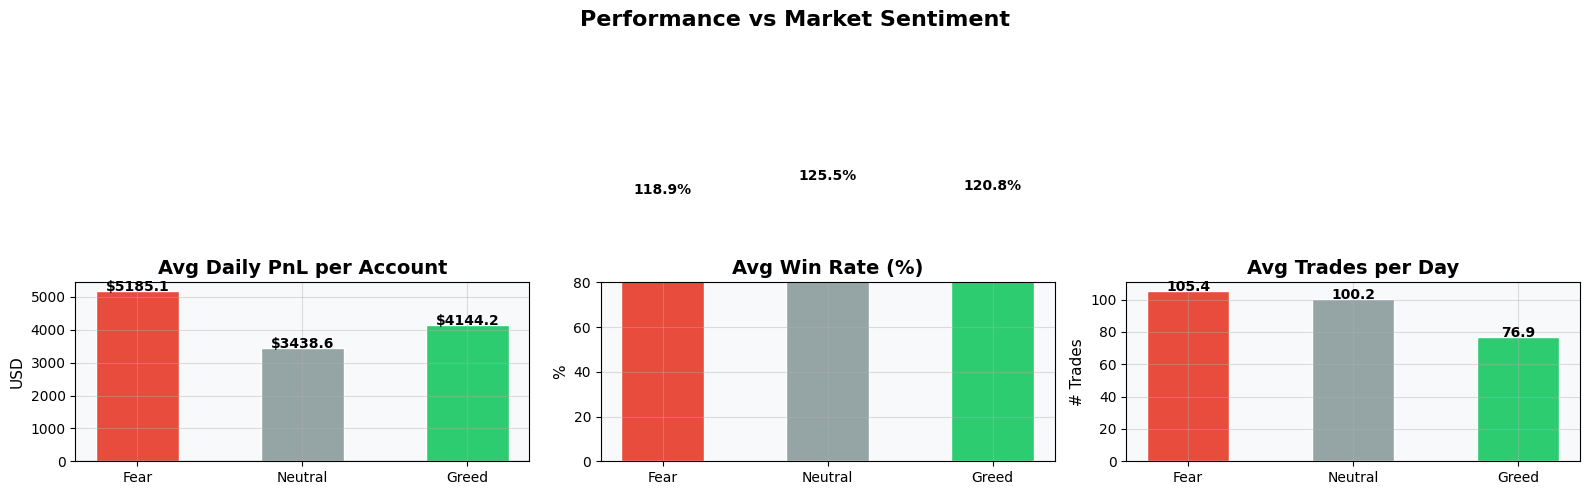

In [19]:
sentiments = ['Fear', 'Neutral', 'Greed']
colors_map = {'Fear': '#E74C3C', 'Neutral': '#95A5A6', 'Greed': '#2ECC71'}


fig, axes = plt.subplots(1, 3, figsize=(16, 5))
fig.suptitle('Performance vs Market Sentiment', fontsize=16, fontweight='bold')

ax = axes[0]
vals = [sent_stats.loc[s, 'avg_pnl'] for s in sentiments]
bars = ax.bar(sentiments, vals,
              color=[colors_map[s] for s in sentiments],
              edgecolor='white', width=0.5)
ax.set_title('Avg Daily PnL per Account', fontweight='bold')
ax.set_ylabel('USD')
ax.axhline(0, color='black', linewidth=0.8)

for bar, v in zip(bars, vals):
    ax.text(bar.get_x() + bar.get_width()/2,
            bar.get_height() + 0.5,
            f'${v:.1f}', ha='center', fontsize=10, fontweight='bold')


ax = axes[1]
vals2 = [sent_stats.loc[s, 'avg_win_rate'] * 100 for s in sentiments]
bars2 = ax.bar(sentiments, vals2,
               color=[colors_map[s] for s in sentiments],
               edgecolor='white', width=0.5)
ax.set_title('Avg Win Rate (%)', fontweight='bold')
ax.set_ylabel('%')
ax.set_ylim(0, 80)
for bar, v in zip(bars2, vals2):
    ax.text(bar.get_x() + bar.get_width()/2,
            bar.get_height() + 0.5,
            f'{v:.1f}%', ha='center', fontsize=10, fontweight='bold')


ax = axes[2]
vals3 = [sent_stats.loc[s, 'avg_trades'] for s in sentiments]
bars3 = ax.bar(sentiments, vals3,
               color=[colors_map[s] for s in sentiments],
               edgecolor='white', width=0.5)
ax.set_title('Avg Trades per Day', fontweight='bold')
ax.set_ylabel('# Trades')
for bar, v in zip(bars3, vals3):
    ax.text(bar.get_x() + bar.get_width()/2,
            bar.get_height() + 0.1,
            f'{v:.1f}', ha='center', fontsize=10, fontweight='bold')
plt.tight_layout()
plt.show()

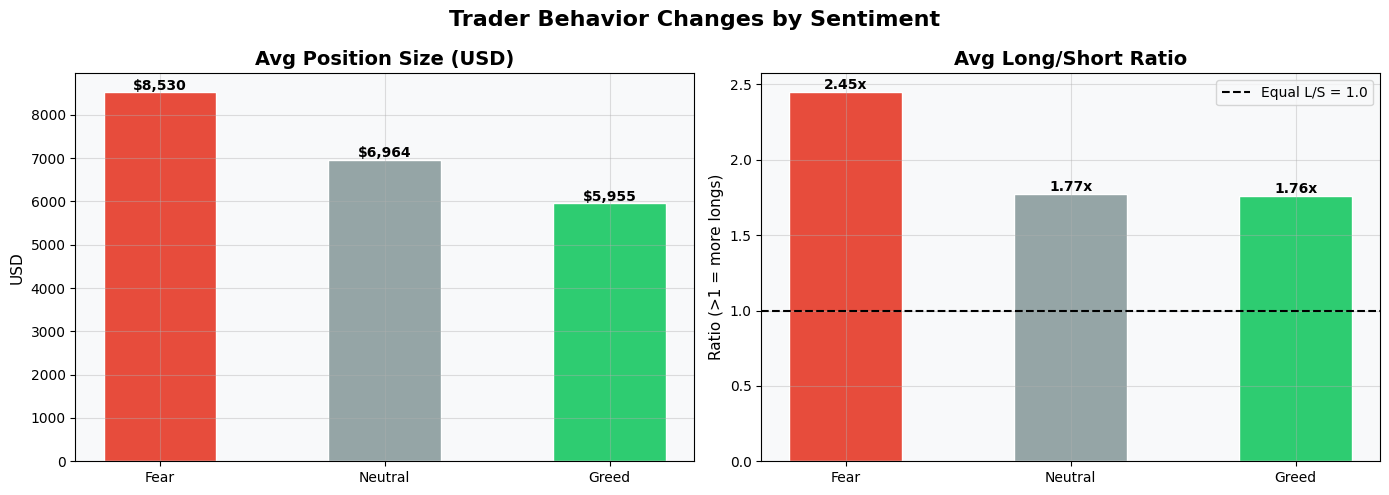

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle('Trader Behavior Changes by Sentiment', fontsize=16, fontweight='bold')

ax = axes[0]
vals4 = [sent_stats.loc[s, 'avg_size'] for s in sentiments]
bars4 = ax.bar(sentiments, vals4,
               color=[colors_map[s] for s in sentiments],
               edgecolor='white', width=0.5)
ax.set_title('Avg Position Size (USD)', fontweight='bold')
ax.set_ylabel('USD')
for bar, v in zip(bars4, vals4):
    ax.text(bar.get_x() + bar.get_width()/2,
            bar.get_height() + 50,
            f'${v:,.0f}', ha='center', fontsize=10, fontweight='bold')

ax = axes[1]
vals5 = [sent_stats.loc[s, 'avg_ls_ratio'] for s in sentiments]
bars5 = ax.bar(sentiments, vals5,
               color=[colors_map[s] for s in sentiments],
               edgecolor='white', width=0.5)

ax.axhline(1.0, color='black', linestyle='--', linewidth=1.5, label='Equal L/S = 1.0')
ax.set_title('Avg Long/Short Ratio', fontweight='bold')
ax.set_ylabel('Ratio (>1 = more longs)')
ax.legend()
for bar, v in zip(bars5, vals5):
    ax.text(bar.get_x() + bar.get_width()/2,
            bar.get_height() + 0.02,
            f'{v:.2f}x', ha='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

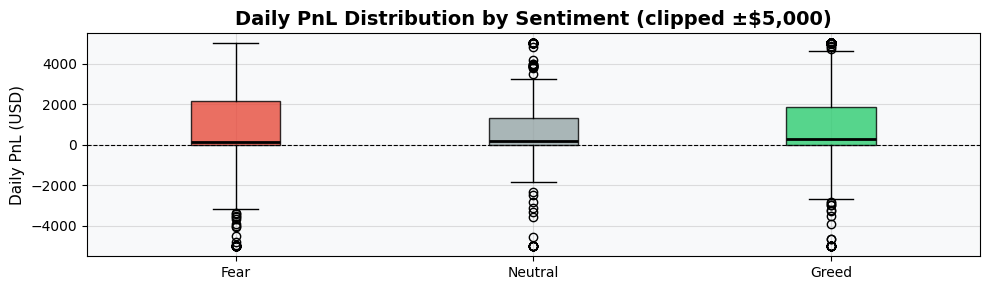

In [21]:
fig, ax = plt.subplots(figsize=(10, 3))

data_box = [
    daily[daily['sentiment'] == s]['daily_pnl'].clip(-5000, 5000).dropna().values
    for s in sentiments
]

bp = ax.boxplot(data_box,
                labels=sentiments,
                patch_artist=True,
                notch=False,
                medianprops=dict(color='black', linewidth=2))

for patch, s in zip(bp['boxes'], sentiments):
    patch.set_facecolor(colors_map[s])
    patch.set_alpha(0.8)

ax.set_title('Daily PnL Distribution by Sentiment (clipped ±$5,000)', fontweight='bold')
ax.set_ylabel('Daily PnL (USD)')
ax.axhline(0, color='black', linewidth=0.8, linestyle='--')

plt.tight_layout()
plt.show()

In [13]:
acct = daily.groupby('Account').agg(
    total_pnl    = ('daily_pnl','sum'),
    avg_pnl      = ('daily_pnl','mean'),
    total_trades = ('num_trades','sum'),
    trading_days = ('date','count'),
    avg_size     = ('avg_size_usd','mean'),
    avg_win_rate = ('win_rate','mean'),
).reset_index()

acct['trades_per_day'] = acct['total_trades'] / acct['trading_days']

med_freq = acct['trades_per_day'].median()
med_size = acct['avg_size'].median()
acct['freq_segment'] = np.where(acct['trades_per_day'] >= med_freq, 'High Frequency', 'Low Frequency')
acct['perf_segment'] = np.where(acct['total_pnl'] > 0, 'Consistent Winner', 'Consistent Loser')
acct['size_segment'] = np.where(acct['avg_size'] >= med_size, 'Large Trader', 'Small Trader')

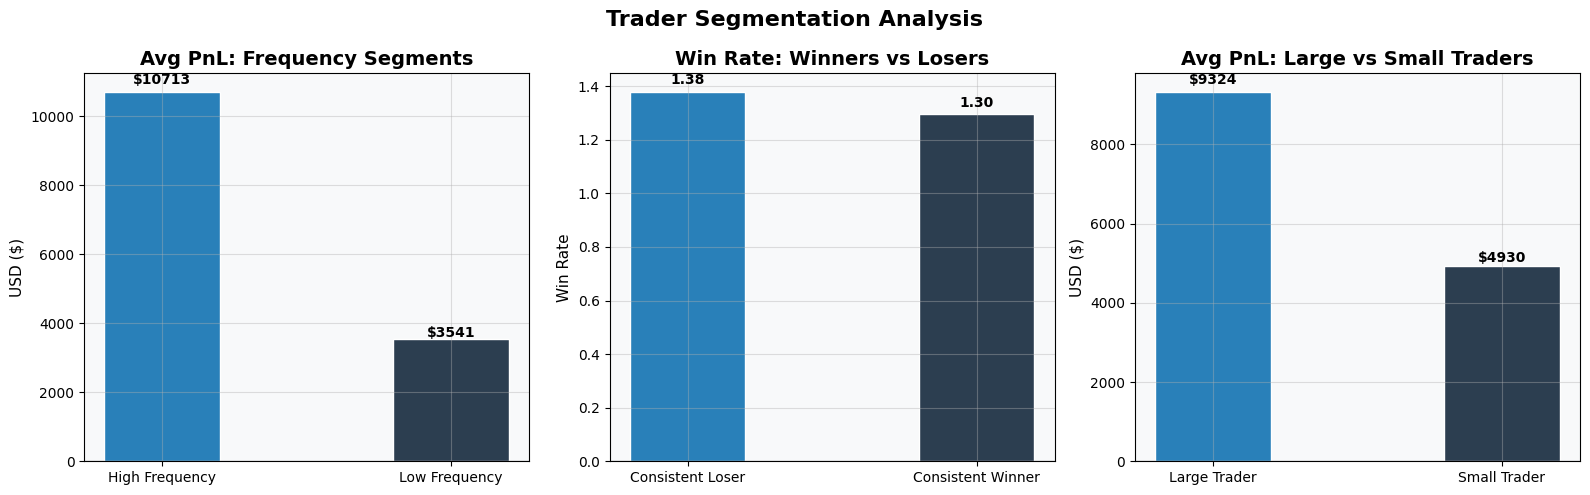

In [22]:
fig, axes = plt.subplots(1, 3, figsize=(16, 5))
fig.suptitle('Trader Segmentation Analysis', fontsize=16, fontweight='bold')


def seg_bar(ax, dataframe, segment_col, metric, title, ylabel, fmt='${:.0f}'):
    groups = dataframe.groupby(segment_col)[metric].mean()
    colors = ['#2980B9', '#2C3E50']
    bars = ax.bar(groups.index, groups.values,
                  color=colors[:len(groups)],
                  edgecolor='white', width=0.4)
    ax.set_title(title, fontweight='bold')
    ax.set_ylabel(ylabel)
    for bar, v in zip(bars, groups.values):
        ax.text(bar.get_x() + bar.get_width()/2,
                bar.get_height() * 1.02,
                fmt.format(v), ha='center', fontsize=10, fontweight='bold')
    ax.axhline(0, color='black', linewidth=0.8)

seg_bar(axes[0], acct, 'freq_segment', 'avg_pnl',
        'Avg PnL: Frequency Segments', 'USD ($)')

seg_bar(axes[1], acct, 'perf_segment', 'avg_win_rate',
        'Win Rate: Winners vs Losers', 'Win Rate', fmt='{:.2f}')

seg_bar(axes[2], acct, 'size_segment', 'avg_pnl',
        'Avg PnL: Large vs Small Traders', 'USD ($)')

plt.tight_layout()
plt.show()

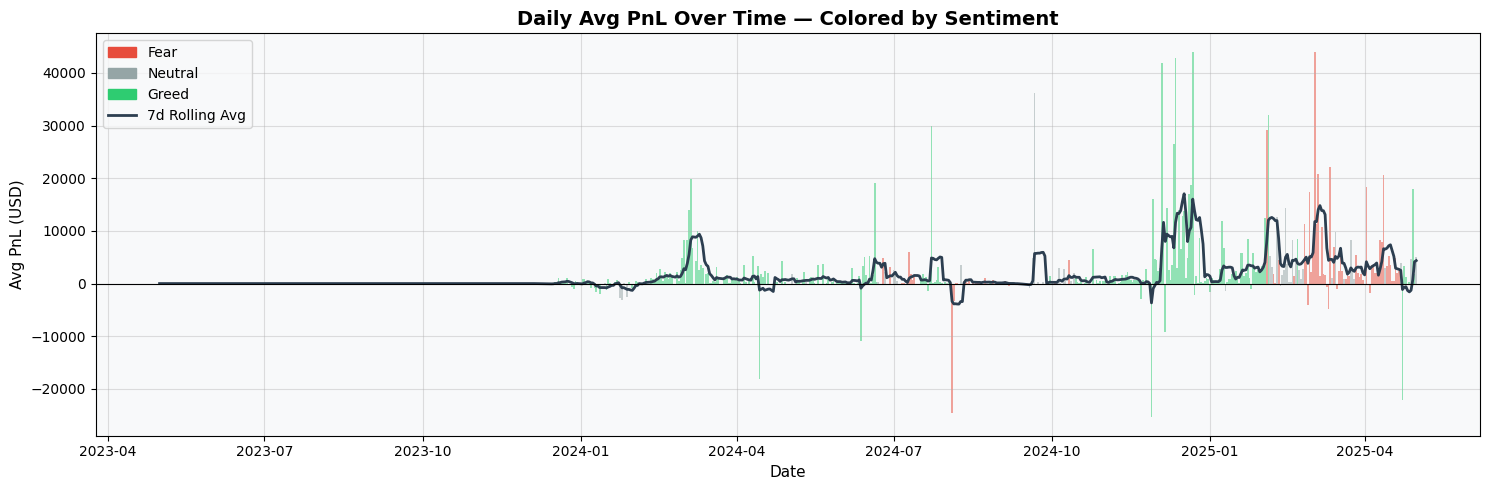

In [23]:
import matplotlib.patches as mpatches


daily_agg = daily.groupby('date').agg(
    avg_pnl   = ('daily_pnl', 'mean'),
    sentiment = ('sentiment', 'first'),
).reset_index().sort_values('date')


daily_agg['pnl_7d'] = daily_agg['avg_pnl'].rolling(7, min_periods=1).mean()

fig, ax = plt.subplots(figsize=(15, 5))


sent_colors = daily_agg['sentiment'].map(colors_map)


ax.bar(daily_agg['date'], daily_agg['avg_pnl'],
       color=sent_colors, alpha=0.5, width=1)


ax.plot(daily_agg['date'], daily_agg['pnl_7d'],
        color='#2C3E50', linewidth=2, label='7-day Rolling Avg')

ax.axhline(0, color='black', linewidth=0.8)
ax.set_title('Daily Avg PnL Over Time — Colored by Sentiment', fontweight='bold')
ax.set_ylabel('Avg PnL (USD)')
ax.set_xlabel('Date')


patches = [mpatches.Patch(color=colors_map[s], label=s) for s in sentiments]
trend_line = plt.Line2D([0], [0], color='#2C3E50', linewidth=2, label='7d Rolling Avg')
ax.legend(handles=patches + [trend_line], loc='upper left')

plt.tight_layout()
plt.show()


In [16]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

daily['profitable'] = (daily['daily_pnl'] > 0).astype(int)

le = LabelEncoder()
daily['sentiment_enc'] = le.fit_transform(daily['sentiment'])

features = ['num_trades','avg_size_usd','win_rate','ls_ratio','sentiment_enc']
X = daily[features].fillna(0)
y = daily['profitable']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

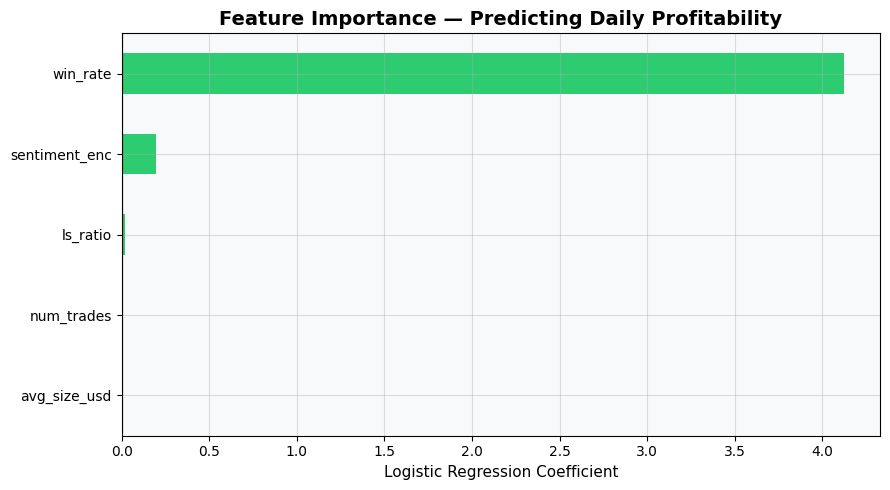

In [24]:
le = LabelEncoder()
daily['sentiment_enc'] = le.fit_transform(daily['sentiment'])

features = ['num_trades', 'avg_size_usd', 'win_rate', 'ls_ratio', 'sentiment_enc']

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)


fig, ax = plt.subplots(figsize=(9, 5))

coefs = pd.Series(model.coef_[0], index=features).sort_values()


bar_colors = ['#2ECC71' if v > 0 else '#E74C3C' for v in coefs]

coefs.plot(kind='barh', ax=ax, color=bar_colors)

ax.set_title('Feature Importance — Predicting Daily Profitability', fontweight='bold')
ax.set_xlabel('Logistic Regression Coefficient')
ax.axvline(0, color='black', linewidth=0.8)

plt.tight_layout()
plt.show()